In [ ]:
# Several Regression Models from Sklearn
This model will predict the values for N_time(time in the network). For N_time prediction, a linear regresion over size/rate is done. Rate information is fetched from fts_aggragated_* index which was previously populated with rate per link per minute.
* import libraries
* create the RSE to site mapping
* get the data
* fit the model
* TODO: test against the data over the next week
* plot plot plot

In [ ]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.linear_model import LinearRegression, Ridge, Lasso,BayesianRidge
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

In [ ]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
data['SIZE_MB'] = data.SIZE/(1024*1024)
data['N_RATE_MB'] = data.N_RATE/(1024*1024)

In [77]:
index_list = []
for i in range(0, DELTA+1):
    index_list.append('fts-aggregates_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%-m'))
indexes = ','.join(index_list)
print (index_list)

period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=10)
transfer_query = {
    "size": 0,
    "_source": ["src", "dest", "timestamp","rate"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "src" : "CERN-PROD" }},
                {"term" : { "dest" : "BNL-ATLAS" }},
                {"range" : {"timestamp" : {  "gte": period_start } }},
                {"range" : {"timestamp" : {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
rates = []
tsindex = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    #print (r.keys())
    #r['timestamp'] = (dt.datetime.strptime(r['timestamp'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    try:
        rates.append([r['src']+'__'+r['dest'],r['timestamp']/1000,r['rate']])
        tsindex.append(r['timestamp']/1000)
    except KeyError:
        continue
    count += 1
print('Reading took',time.time() - st,'seconds.')
rates = pd.DataFrame(rates, columns=['LINK', 'TS', 'RATE'], index=tsindex)

['fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2']
0
Reading took 0.5318975448608398 seconds.


## Fitting several models for link CERN,BNL,Prod Input

In [79]:
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'Production Input'
cut = data.where(data.LINK == src+'__'+dst+'__'+act).dropna()
#link_rate = []
#for t in cut.itertuples():
#    t_index = (t.STARTED - (t.STARTED%60))-60  # link rate at the previous minute
    #print (rates.iloc(t_index))
#    link_rate.append(rates.loc[t_index].RATE)
#cut['LINK_RATE'] = link_rate
    

### making the fit SIZE based

In [80]:
lr1 = LinearRegression(fit_intercept=False)
lr2 = LinearRegression(fit_intercept=False)
lr3 = LinearRegression()
lr4 = LinearRegression()
ls1 = Lasso(fit_intercept=False)
ls2 = Lasso(fit_intercept=False)
ls3 = Lasso()
ls4 = Lasso()
rr1 = Ridge(fit_intercept=False)
rr2 = Ridge(fit_intercept=False)
rr3 = Ridge()
rr4 = Ridge()
#limit = cut.SIZE_MB.min()
#limit = cut.SIZE_MB.max()
limit = 250

below_limit = cut.where(cut.SIZE_MB < limit).dropna()
above_limit = cut.where(cut.SIZE_MB >= limit).dropna()

lr_belowlimit = lr1.fit(below_limit[['SIZE_MB']],below_limit.N_RATE_MB)
lr_abovelimit = lr2.fit(above_limit[['SIZE_MB']],above_limit.N_RATE_MB)
lr_belowlimit_fi = lr3.fit(below_limit[['SIZE_MB']],below_limit.N_RATE_MB)
lr_abovelimit_fi = lr4.fit(above_limit[['SIZE_MB']],above_limit.N_RATE_MB)

ls_belowlimit = ls1.fit(below_limit[['SIZE_MB']],below_limit.N_RATE_MB)
ls_abovelimit = ls2.fit(above_limit[['SIZE_MB']],above_limit.N_RATE_MB)
ls_belowlimit_fi = ls3.fit(below_limit[['SIZE_MB']],below_limit.N_RATE_MB)
ls_abovelimit_fi = ls4.fit(above_limit[['SIZE_MB']],above_limit.N_RATE_MB)

rr_belowlimit = rr1.fit(below_limit[['SIZE_MB']],below_limit.N_RATE_MB)
rr_abovelimit = rr2.fit(above_limit[['SIZE_MB']],above_limit.N_RATE_MB)
rr_belowlimit_fi = rr3.fit(below_limit[['SIZE_MB']],below_limit.N_RATE_MB)
rr_abovelimit_fi = rr4.fit(above_limit[['SIZE_MB']],above_limit.N_RATE_MB)

below_limit['N_LR_FI'] = lr_belowlimit_fi.predict(below_limit[['SIZE_MB']])
above_limit['N_LR_FI'] = lr_abovelimit_fi.predict(above_limit[['SIZE_MB']])
below_limit['N_LR'] = lr_belowlimit.predict(below_limit[['SIZE_MB']])
above_limit['N_LR'] = lr_abovelimit.predict(above_limit[['SIZE_MB']])

below_limit['N_LS_FI'] = ls_belowlimit_fi.predict(below_limit[['SIZE_MB']])
above_limit['N_LS_FI'] = ls_abovelimit_fi.predict(above_limit[['SIZE_MB']])
below_limit['N_LS'] = ls_belowlimit.predict(below_limit[['SIZE_MB']])
above_limit['N_LS'] = ls_abovelimit.predict(above_limit[['SIZE_MB']])

below_limit['N_RR_FI'] = rr_belowlimit_fi.predict(below_limit[['SIZE_MB']])
above_limit['N_RR_FI'] = rr_abovelimit_fi.predict(above_limit[['SIZE_MB']])
below_limit['N_RR'] = rr_belowlimit.predict(below_limit[['SIZE_MB']])
above_limit['N_RR'] = rr_abovelimit.predict(above_limit[['SIZE_MB']])

cut = below_limit.append(above_limit)

### plotting the fit

NETWORK rate/pred for CERN-PROD --> BNL-ATLAS Production Input


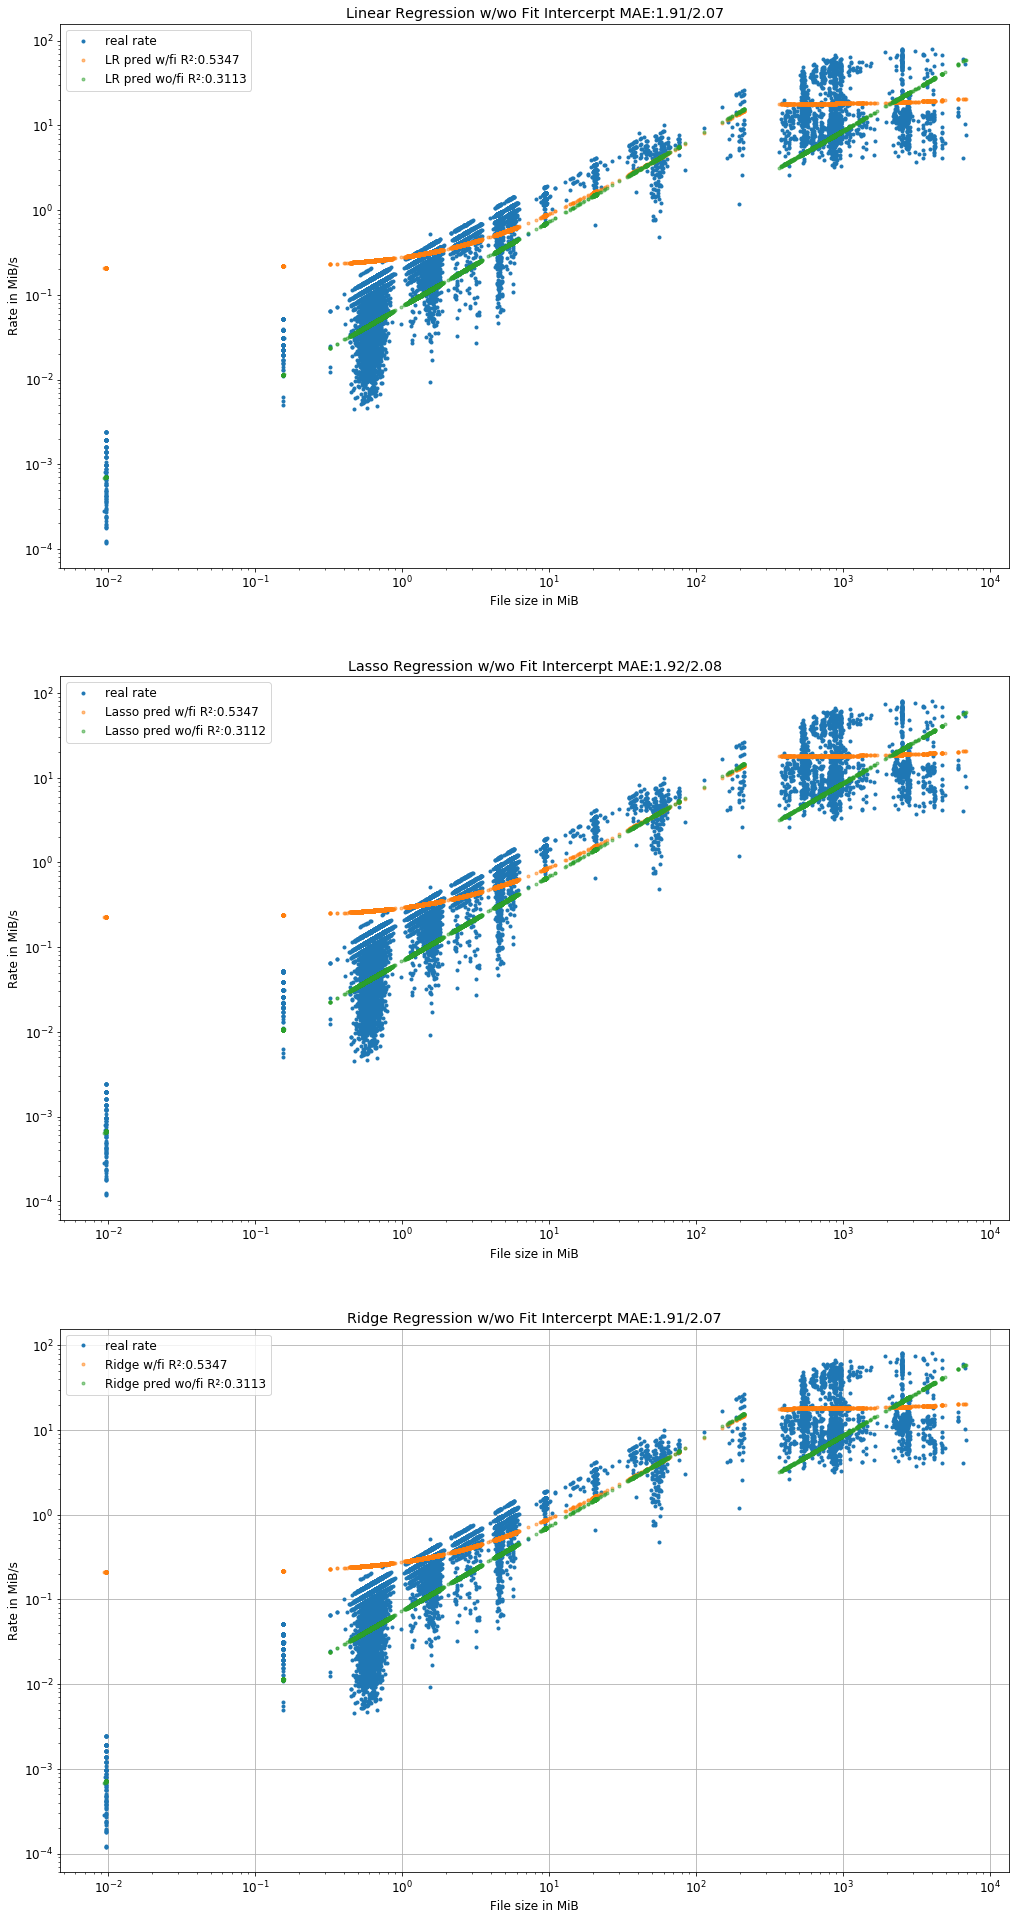

In [81]:
lr_fi_mae = mae(cut.N_RATE_MB, cut.N_LR_FI)
lr_mae = mae(cut.N_RATE_MB, cut.N_LR)
ls_fi_mae = mae(cut.N_RATE_MB, cut.N_LS_FI)
ls_mae = mae(cut.N_RATE_MB, cut.N_LS)
rr_fi_mae = mae(cut.N_RATE_MB, cut.N_RR_FI)
rr_mae = mae(cut.N_RATE_MB, cut.N_RR)

lr_fi_mse = mse(cut.N_RATE_MB, cut.N_LR_FI)
lr_mse = mse(cut.N_RATE_MB, cut.N_LR)
ls_fi_mse = mse(cut.N_RATE_MB, cut.N_LS_FI)
ls_mse = mse(cut.N_RATE_MB, cut.N_LS)
rr_fi_mse = mse(cut.N_RATE_MB, cut.N_RR_FI)
rr_mse = mse(cut.N_RATE_MB, cut.N_RR)

lr_fi_r2 = r2(cut.N_RATE_MB, cut.N_LR_FI)
lr_r2 = r2(cut.N_RATE_MB, cut.N_LR)
ls_fi_r2 = r2(cut.N_RATE_MB, cut.N_LS_FI)
ls_r2 = r2(cut.N_RATE_MB, cut.N_LS)
rr_fi_r2 = r2(cut.N_RATE_MB, cut.N_RR_FI)
rr_r2 = r2(cut.N_RATE_MB, cut.N_RR)

fig, (ax1,ax2,ax3) = plt.subplots(3,1)
ax1.plot(cut.SIZE_MB, cut.N_RATE_MB,'.', label='real rate')
ax1.plot(cut.SIZE_MB, cut.N_LR_FI,'.', label='LR pred w/fi R²:%.04f'%lr_fi_r2, alpha=.5)
ax1.plot(cut.SIZE_MB, cut.N_LR,'.', label='LR pred wo/fi R²:%.04f'%lr_r2, alpha=.5)


ax2.plot(cut.SIZE_MB, cut.N_RATE_MB,'.', label='real rate')
ax2.plot(cut.SIZE_MB, cut.N_LS_FI,'.', label='Lasso pred w/fi R²:%.04f'%ls_fi_r2, alpha=.5)
ax2.plot(cut.SIZE_MB, cut.N_LS,'.', label='Lasso pred wo/fi R²:%.04f'%ls_r2, alpha=.5)

ax3.plot(cut.SIZE_MB, cut.N_RATE_MB,'.', label='real rate')
ax3.plot(cut.SIZE_MB, cut.N_RR_FI,'.', label='Ridge w/fi R²:%.04f'%rr_fi_r2, alpha=.5)
ax3.plot(cut.SIZE_MB, cut.N_RR,'.', label='Ridge pred wo/fi R²:%.04f'%rr_r2, alpha=.5)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('File size in MiB')
ax1.set_ylabel('Rate in MiB/s')
ax2.set_xlabel('File size in MiB')
ax2.set_ylabel('Rate in MiB/s')
ax3.set_xlabel('File size in MiB')
ax3.set_ylabel('Rate in MiB/s')

ax1.set_title('Linear Regression w/wo Fit Intercerpt MAE:%.02f/%.02f'%(lr_fi_mae,lr_mae))
ax2.set_title('Lasso Regression w/wo Fit Intercerpt MAE:%.02f/%.02f'%(ls_fi_mae,ls_mae))
ax3.set_title('Ridge Regression w/wo Fit Intercerpt MAE:%.02f/%.02f'%(rr_fi_mae,rr_mae))

print('NETWORK rate/pred for CERN-PROD --> BNL-ATLAS Production Input')


#fig = plt.gcf()
fig.set_size_inches(17, 34)
plt.legend()
plt.grid()
plt.show()

## Using same fit to predict data of the following week 08/02 to 15/02

In [67]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-08'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data2 = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data2.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data2 = pd.DataFrame(data2, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data2['Q_TIME'] = data2['STARTED'] - data2['SUBMITTED']
data2['N_RATE'] = data2.SIZE/(data2['ENDED'] - data2['STARTED'])
data2['T_TIME'] = data2['ENDED'] - data2['SUBMITTED']
data2['SIZE_MB'] = data2.SIZE/(1024*1024)
data2['N_RATE_MB'] = data2.N_RATE/(1024*1024)

['fts_2017-02-07', 'fts_2017-02-08', 'fts_2017-02-09', 'fts_2017-02-10', 'fts_2017-02-11', 'fts_2017-02-12', 'fts_2017-02-13', 'fts_2017-02-14', 'fts_2017-02-15']
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
Reading took 1749.7403216362 seconds.


In [68]:
index_list = []
for i in range(0, DELTA+1):
    index_list.append('fts-aggregates_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%-m'))
indexes = ','.join(index_list)
print (index_list)

period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=10)
transfer_query = {
    "size": 0,
    "_source": ["src", "dest", "timestamp","rate"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "src" : "CERN-PROD" }},
                {"term" : { "dest" : "BNL-ATLAS" }},
                {"range" : {"timestamp" : {  "gte": period_start } }},
                {"range" : {"timestamp" : {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
rates = []
tsindex = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    #print (r.keys())
    #r['timestamp'] = (dt.datetime.strptime(r['timestamp'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    try:
        rates.append([r['src']+'__'+r['dest'],r['timestamp']/1000,r['rate']])
        tsindex.append(r['timestamp']/1000)
    except KeyError:
        continue
    count += 1
print('Reading took',time.time() - st,'seconds.')
rates = pd.DataFrame(rates, columns=['LINK', 'TS', 'RATE'], index=tsindex)

['fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2']
0
Reading took 0.3006467819213867 seconds.


## Selecting CERN,BNL,Prod Input data

In [89]:
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'Production Input'
cut = data2.where(data2.LINK == src+'__'+dst+'__'+act).dropna()
link_rate = []
for t in cut.itertuples():
    t_index = (t.STARTED - (t.STARTED%60))-60  # link rate at the previous minute
    #print (rates.iloc(t_index))
    link_rate.append(rates.loc[t_index].RATE)
cut['LINK_RATE'] = link_rate
cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
print(len(cut))

20509


In [90]:
limit = 250

below_limit = cut.where(cut.SIZE_MB < limit).dropna()
above_limit = cut.where(cut.SIZE_MB >= limit).dropna()

below_limit['N_LR_FI'] = lr_belowlimit_fi.predict(below_limit[['SIZE_MB']])
above_limit['N_LR_FI'] = lr_abovelimit_fi.predict(above_limit[['SIZE_MB']])
below_limit['N_LR'] = lr_belowlimit.predict(below_limit[['SIZE_MB']])
above_limit['N_LR'] = lr_abovelimit.predict(above_limit[['SIZE_MB']])

below_limit['N_LS_FI'] = ls_belowlimit_fi.predict(below_limit[['SIZE_MB']])
above_limit['N_LS_FI'] = ls_abovelimit_fi.predict(above_limit[['SIZE_MB']])
below_limit['N_LS'] = ls_belowlimit.predict(below_limit[['SIZE_MB']])
above_limit['N_LS'] = ls_abovelimit.predict(above_limit[['SIZE_MB']])

below_limit['N_RR_FI'] = rr_belowlimit_fi.predict(below_limit[['SIZE_MB']])
above_limit['N_RR_FI'] = rr_abovelimit_fi.predict(above_limit[['SIZE_MB']])
below_limit['N_RR'] = rr_belowlimit.predict(below_limit[['SIZE_MB']])
above_limit['N_RR'] = rr_abovelimit.predict(above_limit[['SIZE_MB']])

cut = below_limit.append(above_limit)

### Ploting the fit

NETWORK rate/pred for CERN-PROD --> BNL-ATLAS Production Input


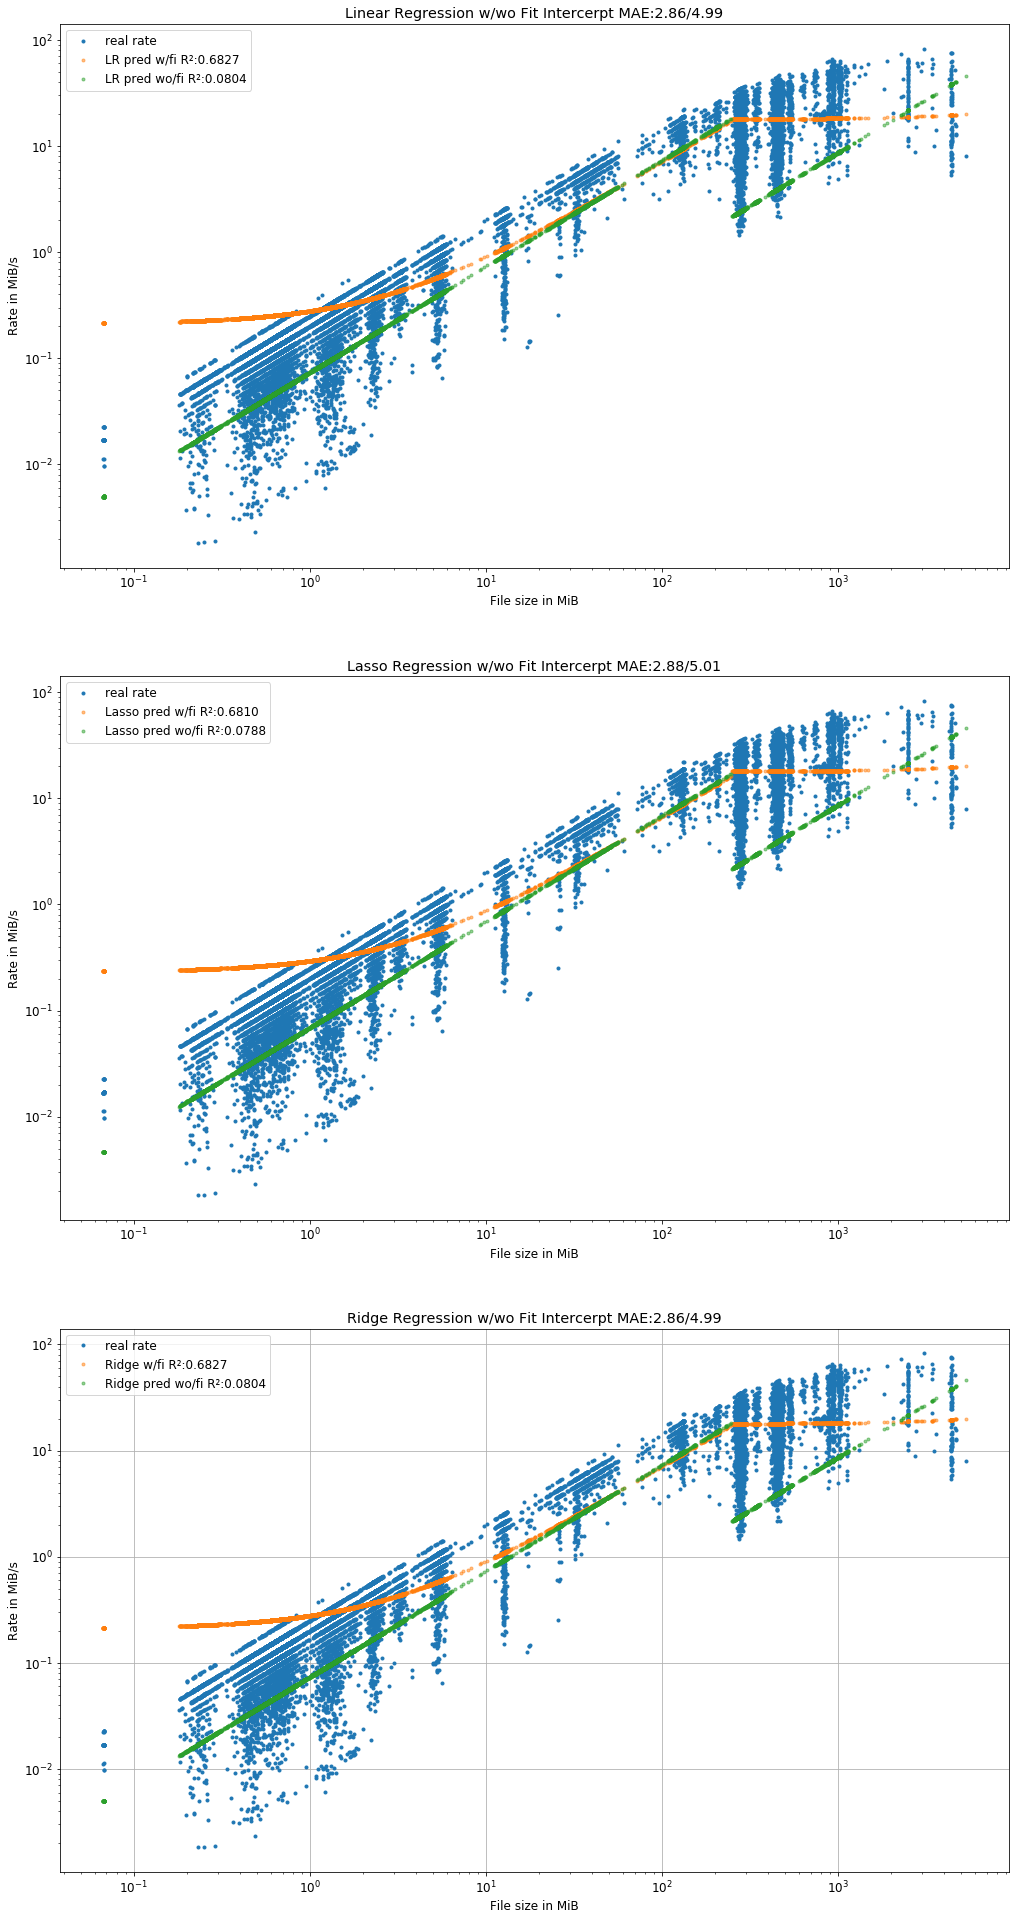

In [91]:
lr_fi_mae = mae(cut.N_RATE_MB, cut.N_LR_FI)
lr_mae = mae(cut.N_RATE_MB, cut.N_LR)
ls_fi_mae = mae(cut.N_RATE_MB, cut.N_LS_FI)
ls_mae = mae(cut.N_RATE_MB, cut.N_LS)
rr_fi_mae = mae(cut.N_RATE_MB, cut.N_RR_FI)
rr_mae = mae(cut.N_RATE_MB, cut.N_RR)

lr_fi_mse = mse(cut.N_RATE_MB, cut.N_LR_FI)
lr_mse = mse(cut.N_RATE_MB, cut.N_LR)
ls_fi_mse = mse(cut.N_RATE_MB, cut.N_LS_FI)
ls_mse = mse(cut.N_RATE_MB, cut.N_LS)
rr_fi_mse = mse(cut.N_RATE_MB, cut.N_RR_FI)
rr_mse = mse(cut.N_RATE_MB, cut.N_RR)

lr_fi_r2 = r2(cut.N_RATE_MB, cut.N_LR_FI)
lr_r2 = r2(cut.N_RATE_MB, cut.N_LR)
ls_fi_r2 = r2(cut.N_RATE_MB, cut.N_LS_FI)
ls_r2 = r2(cut.N_RATE_MB, cut.N_LS)
rr_fi_r2 = r2(cut.N_RATE_MB, cut.N_RR_FI)
rr_r2 = r2(cut.N_RATE_MB, cut.N_RR)

fig, (ax1,ax2,ax3) = plt.subplots(3,1)
ax1.plot(cut.SIZE_MB, cut.N_RATE_MB,'.', label='real rate')
ax1.plot(cut.SIZE_MB, cut.N_LR_FI,'.', label='LR pred w/fi R²:%.04f'%lr_fi_r2, alpha=.5)
ax1.plot(cut.SIZE_MB, cut.N_LR,'.', label='LR pred wo/fi R²:%.04f'%lr_r2, alpha=.5)


ax2.plot(cut.SIZE_MB, cut.N_RATE_MB,'.', label='real rate')
ax2.plot(cut.SIZE_MB, cut.N_LS_FI,'.', label='Lasso pred w/fi R²:%.04f'%ls_fi_r2, alpha=.5)
ax2.plot(cut.SIZE_MB, cut.N_LS,'.', label='Lasso pred wo/fi R²:%.04f'%ls_r2, alpha=.5)

ax3.plot(cut.SIZE_MB, cut.N_RATE_MB,'.', label='real rate')
ax3.plot(cut.SIZE_MB, cut.N_RR_FI,'.', label='Ridge w/fi R²:%.04f'%rr_fi_r2, alpha=.5)
ax3.plot(cut.SIZE_MB, cut.N_RR,'.', label='Ridge pred wo/fi R²:%.04f'%rr_r2, alpha=.5)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('File size in MiB')
ax1.set_ylabel('Rate in MiB/s')
ax2.set_xlabel('File size in MiB')
ax2.set_ylabel('Rate in MiB/s')
ax3.set_xlabel('File size in MiB')
ax3.set_ylabel('Rate in MiB/s')
ax1.set_title('Linear Regression w/wo Fit Intercerpt MAE:%.02f/%.02f'%(lr_fi_mae,lr_mae))
ax2.set_title('Lasso Regression w/wo Fit Intercerpt MAE:%.02f/%.02f'%(ls_fi_mae,ls_mae))
ax3.set_title('Ridge Regression w/wo Fit Intercerpt MAE:%.02f/%.02f'%(rr_fi_mae,rr_mae))

print('NETWORK rate/pred for CERN-PROD --> BNL-ATLAS Production Input')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('File size in MiB')
plt.ylabel('Rate in MiB/s')

#fig = plt.gcf()
fig.set_size_inches(17, 34)
plt.legend()
plt.grid()
plt.show()

20509


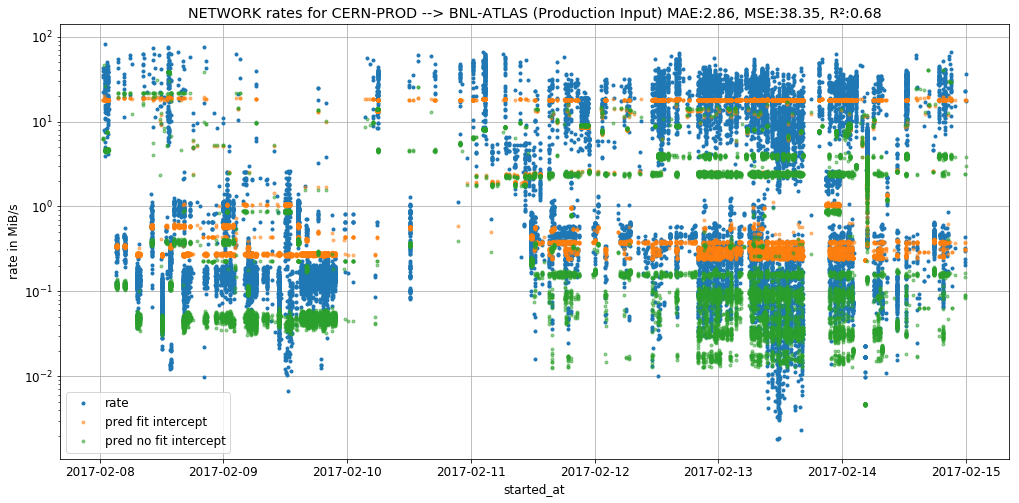

In [98]:
plt.plot(cut.index, cut.N_RATE_MB,'.', label='rate')
plt.plot(cut.index, cut.N_LS_FI, '.', alpha=0.5, label='pred fit intercept')
plt.plot(cut.index, cut.N_LS, '.', alpha=0.5, label='pred no fit intercept')
print(len(cut))
#s.expanding().mean()
n_mae = mae(cut.N_RATE_MB, cut.N_LR_FI)
n_mse = mse(cut.N_RATE_MB, cut.N_LR_FI)
n_r2 = r2(cut.N_RATE_MB, cut.N_LS_FI)
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS (Production Input) MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(n_mae, n_mse,n_r2))
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('started_at')
plt.ylabel('rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()